In [1]:
import xgboost as xgb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from rdkit import DataStructs, Chem
from rdkit.Chem import AllChem
import shap
from sklearn.model_selection import cross_validate
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,AdaBoostRegressor,BaggingRegressor,ExtraTreesRegressor,GradientBoostingRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,ARDRegression,BayesianRidge,ElasticNet,GammaRegressor,HuberRegressor
from sklearn.linear_model import Lasso, LassoLars, LinearRegression, LogisticRegression, PassiveAggressiveRegressor,Ridge,SGDRegressor
import gc
import glob
import os
import random
import time
from datetime import date, datetime

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn import model_selection
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [36]:
data = pd.read_excel('D:/python/rdkit/data2.xlsx')



In [37]:
import random
from rdkit import Chem
aug_data = 300

def randomize_smiles(mol, random_type=None, isomericSmiles=True):
   
    if random_type is None:
        
        random_type = np.random.choice(['unrestricted', 'restricted', 'rotated'])

    if random_type == "unrestricted":
        return Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=isomericSmiles)
    elif random_type == "restricted":
        new_atom_order = list(range(mol.GetNumAtoms()))
        random.shuffle(new_atom_order)
        random_mol = Chem.RenumberAtoms(mol, newOrder=new_atom_order)
        return Chem.MolToSmiles(random_mol, canonical=False, isomericSmiles=isomericSmiles)
    elif random_type == 'rotated':
        n_atoms = mol.GetNumAtoms()
        rotation_index = random.randint(0, n_atoms-1)
        atoms = list(range(n_atoms))
        new_atoms_order = (atoms[rotation_index%len(atoms):]+atoms[:rotation_index%len(atoms)])
        rotated_mol = Chem.RenumberAtoms(mol,new_atoms_order)
        return Chem.MolToSmiles(rotated_mol, canonical=False, isomericSmiles=isomericSmiles)
    raise ValueError("Type '{}' is not valid".format(random_type))

smiles = list(data["a-smile"])
permeability = list(data["Permeability"])
smilesb = list(data["b-smile"])

aug_smiles=[]
aug_permeability=[]
aug_smilesb=[]
for sml, per, sml2 in zip(smiles, permeability, smilesb):
    
    new_smls = []
    new_smls.append(sml)
    aug_permeability.append(per)
    aug_smilesb.append(sml2)
    for _ in range(aug_data):
        
        try:
            new_sml = randomize_smiles(Chem.MolFromSmiles(sml))
            if new_sml not in new_smls:
                new_smls.append(new_sml)
                aug_permeability.append(per)
                aug_smilesb.append(sml2)
        except:     
            continue
    aug_smiles.extend(new_smls)

aug_df_PerDB = pd.DataFrame(data={
    "SMILES": aug_smiles,
    "Solubility": aug_permeability,
    "SMILESb": aug_smilesb,
})

print(f"The dataset was augmented from {len(data)} to {len(aug_df_PerDB)}.")

The dataset was augmented from 583 to 17403.


In [38]:
aug_df_PerDB

,SMILES,Solubility,SMILESb
0,N1CCNCC1,7.5,C
1,C1CNCCN1,7.5,C
2,C1NCCNC1,7.5,C
3,N1CCNCC1,7.0,C
4,C1NCCNC1,7.0,C
...,...,...,...
17398,C1(COC(=O)c2cc(O)c(O)c(c2)O)C(O)C(OC(=O)c2cc(O...,12.0,C
17399,O=C(c1cc(O)c(O)c(O)c1)OC1C(O)C(OC(c2cc(O)c(O)c...,12.0,C
17400,OC1C(OC(C(O)C1OC(c1cc(O)c(O)c(c1)O)=O)OC(=O)c1...,12.0,C
17401,C(c1cc(O)c(c(c1)O)O)(=O)OC1C(O)C(OC(c2cc(O)c(O...,12.0,C


In [5]:
class morgan_fp:
    def __init__(self, radius, length):
        self.radius = radius
        self.length = length
    def __call__(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, 2048)
        npfp = np.array(list(fp.ToBitString())).astype('float32')
        return npfp

In [6]:
fp = morgan_fp(0,2048)
aug_df_PerDB['SMILES'] = aug_df_PerDB['SMILES'].apply(fp)
#data['b-fp'] = data['b-smile'].apply(fp)

In [7]:
x_a=np.array(list(aug_df_PerDB['SMILES']))

In [8]:
len(x_a)

17501

In [9]:
fp = morgan_fp(0,2048)
aug_df_PerDB['SMILESb'] = aug_df_PerDB['SMILESb'].apply(fp)

In [10]:
x_b=np.array(list(aug_df_PerDB['SMILESb']))

In [11]:
len(x_b)

17501

In [12]:
import numpy as np

# Assuming x_a and x_b are already defined

# Add the arrays element-wise
result = x_a + x_b

In [13]:
len(result)

17501

In [14]:
x=result


In [15]:
y = aug_df_PerDB.iloc[:,1]
y

0         7.5
1         7.5
2         7.5
3         7.0
4         7.0
         ... 
17496    12.0
17497    12.0
17498    12.0
17499    12.0
17500    12.0
Name: Solubility, Length: 17501, dtype: float64

In [16]:
import numpy as np

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [17]:
import catboost as cb
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
#import shap
#from matplotlib import pyplot as pltfrom sklearn.datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from catboost import CatBoostClassifier, FeaturesData


In [18]:
train_dataset = cb.Pool(X_train, Y_train) 
test_dataset = cb.Pool(X_test, Y_test)

In [19]:
model = cb.CatBoostRegressor()
model.fit(X_train, Y_train)

Learning rate set to 0.062125
0:	learn: 7.0414939	total: 85ms	remaining: 1m 24s
1:	learn: 6.8661466	total: 88.8ms	remaining: 44.3s
2:	learn: 6.7147632	total: 91.5ms	remaining: 30.4s
3:	learn: 6.5663976	total: 94.8ms	remaining: 23.6s
4:	learn: 6.4313330	total: 98.4ms	remaining: 19.6s
5:	learn: 6.3131309	total: 102ms	remaining: 16.9s
6:	learn: 6.2092044	total: 106ms	remaining: 15.1s
7:	learn: 6.1078930	total: 110ms	remaining: 13.6s
8:	learn: 6.0202827	total: 114ms	remaining: 12.5s
9:	learn: 5.9390106	total: 117ms	remaining: 11.6s
10:	learn: 5.8722032	total: 123ms	remaining: 11.1s
11:	learn: 5.8109294	total: 127ms	remaining: 10.5s
12:	learn: 5.7562733	total: 130ms	remaining: 9.89s
13:	learn: 5.7108214	total: 133ms	remaining: 9.39s
14:	learn: 5.6666075	total: 137ms	remaining: 8.98s
15:	learn: 5.6266503	total: 141ms	remaining: 8.64s
16:	learn: 5.6030599	total: 143ms	remaining: 8.27s
17:	learn: 5.5717429	total: 146ms	remaining: 7.96s
18:	learn: 5.5413706	total: 150ms	remaining: 7.73s
19:	lea

In [110]:
model = cb.CatBoostRegressor(iterations=10,learning_rate=1,depth=16)
model.fit(X_train, Y_train)

0:	learn: 5.3633689	total: 1.03ms	remaining: 9.24ms
1:	learn: 5.1356829	total: 17.7ms	remaining: 70.8ms
2:	learn: 5.1154653	total: 20.7ms	remaining: 48.2ms
3:	learn: 5.1146676	total: 21.4ms	remaining: 32.2ms
4:	learn: 5.1060424	total: 23.4ms	remaining: 23.4ms
5:	learn: 5.1018205	total: 24.4ms	remaining: 16.2ms
6:	learn: 5.1004401	total: 25.3ms	remaining: 10.8ms
7:	learn: 5.0903733	total: 40.9ms	remaining: 10.2ms
8:	learn: 5.0896137	total: 44.2ms	remaining: 4.92ms
9:	learn: 5.0882433	total: 49.5ms	remaining: 0us


In [20]:
Y_pred_train = model.predict(X_train)

In [21]:

print('Mean squared error (RMSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Mean squared error (RMSE): 5.26
Coefficient of determination (R^2): 0.47


In [22]:
#predicts the X_test
Y_pred_test = model.predict(X_test)

In [23]:

print('Mean squared error (RMSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Mean squared error (RMSE): 5.31
Coefficient of determination (R^2): 0.46


In [24]:
from sklearn.metrics import mean_absolute_error

In [25]:
mae = mean_absolute_error(Y_test, Y_pred_test)
mae

3.7912372919530326

In [18]:
from sklearn.ensemble import RandomForestRegressor
model2 = RandomForestRegressor(n_estimators=100, random_state=42)
model2.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [19]:
Y_pred_train = model2.predict(X_train)
#predicts the X_train
#print('Coefficients:', model.coef_)
#print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Mean squared error (MSE): 5.24
Coefficient of determination (R^2): 0.48


In [20]:
Y_pred_test = model2.predict(X_test)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Mean squared error (MSE): 5.06
Coefficient of determination (R^2): 0.48


In [21]:
mae = mean_absolute_error(Y_test, Y_pred_test)
mae

3.613907848206949

In [26]:
import shap
from sklearn.preprocessing import StandardScaler
import os
import sys

In [27]:
scaler = StandardScaler()

In [29]:
X = X_test

X2= scaler.fit_transform(X)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X2)




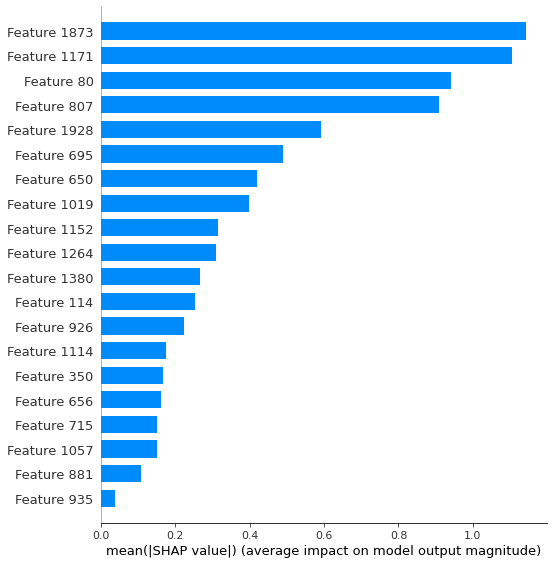

In [30]:
shap.summary_plot(shap_values, X_test, plot_type="bar",show=False,max_display=20,plot_size=0.4) 
#shap.summary_plot(shap_values, max_display=12, plot_type="bar",show=False)
plt.savefig('importantcat.pdf',bbox_inches='tight',dpi = 1000)

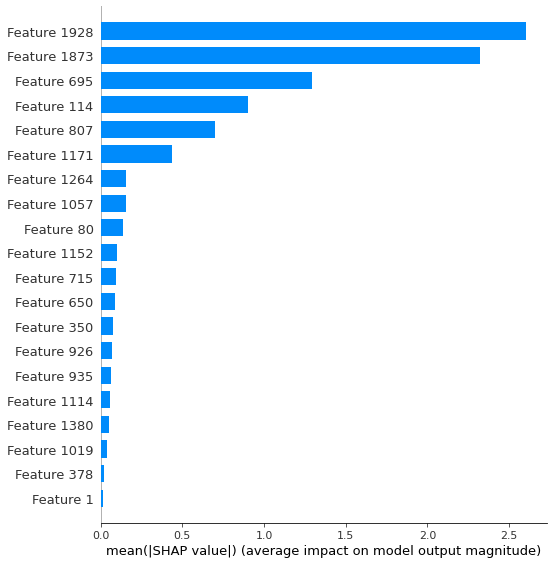

In [27]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

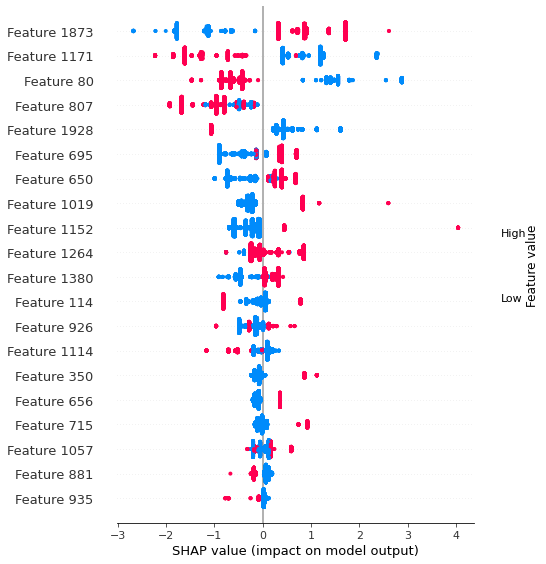

In [31]:
shap.summary_plot(shap_values, X_test, plot_type="dot", plot_size=0.4, show=False,max_display=20)
plt.savefig('important2cat.pdf',bbox_inches='tight',dpi = 1000)

In [ ]:
shap.summary_plot(shap_values, X2, plot_type="dot", plot_size=0.6, show=False,max_display=20)
plt.savefig('scratcch.pdf',bbox_inches='tight',dpi = 1000)

In [ ]:
shap.summary_plot(shap_values, max_display=12, plot_type="bar",show=False)
plt.savefig('scratcch.pdf',bbox_inches='tight',dpi = 1000)

In [ ]:
#data['f_0']

In [42]:
z=aug_df_PerDB.iloc[:,0]
z

0                                                 N1CCNCC1
1                                                 C1CNCCN1
2                                                 C1NCCNC1
3                                                 N1CCNCC1
4                                                 C1NCCNC1
                               ...                        
17398    C1(COC(=O)c2cc(O)c(O)c(c2)O)C(O)C(OC(=O)c2cc(O...
17399    O=C(c1cc(O)c(O)c(O)c1)OC1C(O)C(OC(c2cc(O)c(O)c...
17400    OC1C(OC(C(O)C1OC(c1cc(O)c(O)c(c1)O)=O)OC(=O)c1...
17401    C(c1cc(O)c(c(c1)O)O)(=O)OC1C(O)C(OC(c2cc(O)c(O...
17402    O=C(c1cc(O)c(O)c(O)c1)OC1C(O)C(COC(=O)c2cc(O)c...
Name: SMILES, Length: 17403, dtype: object

In [68]:
mol=z[16000]
mol

'c1(C(C(F)(F)F)(O)C(F)(F)F)c(N)ccc(Cc2ccc(N)c(C(O)(C(F)(F)F)C(F)(F)F)c2)c1'

In [108]:
mol0='C(C)(C)(C1=CC=C(C=C1)O)C1=CC=C(C=C1)O'
mol0

'C(C)(C)(C1=CC=C(C=C1)O)C1=CC=C(C=C1)O'

In [44]:
from rdkit.Chem import rdMolDescriptors

In [69]:
w = Chem.MolFromSmiles(mol)
w

bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(w, radius=0, bitInfo=bi, nBits = 2048)
# show 10 of the set bits:
obl=list(fp.GetOnBits())[:]
obl

[80, 114, 807, 1171, 1380, 1873, 1928]

In [71]:
i=1
u=1264

while i<17400:
    w = Chem.MolFromSmiles(z[i])

    bi = {}
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(w, radius=2, bitInfo=bi, nBits = 2048)
# show 10 of the set bits:
    j=list(fp.GetOnBits())[:]

    if u in j:
    #if a==0.97 and b==0.81:
        break
    #u=r2_score(Y_test, Y_pred_test)
    #b=round(u,2)
    
    
    i+=1
i

17400

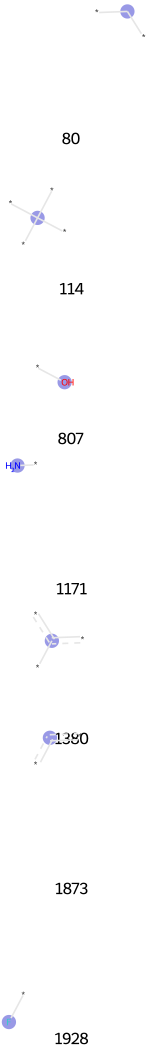

In [70]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
tpls = [(w,x,bi) for x in fp.GetOnBits()]
p=Draw.DrawMorganBits(tpls[:],molsPerRow=1,legends=[str(x) for x in fp.GetOnBits()][:])
dpi=1200
p

In [113]:
def getSubstructSmi(mol,atomID,radius):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))
    else:
        atomsToUse = [atomID]
        env=None
    symbols = []

    smi = Chem.MolFragmentToSmiles(mol,atomsToUse,bondsToUse=env,allHsExplicit=True, allBondsExplicit=True, rootedAtAtom=atomID)
    smi2 = Chem.MolFragmentToSmiles(mol,atomsToUse,bondsToUse=env,atomSymbols=symbols, allBondsExplicit=True, rootedAtAtom=atomID)
    return smi,smi2

In [114]:
bi_bz = {}
fp_bz = AllChem.GetMorganFingerprintAsBitVect(w,radius=2,nBits=2048,bitInfo=bi_bz)
fp_bz

In [115]:
bz = Chem.MolFromSmiles('N1CCNCC1')
fp_bz = AllChem.GetMorganFingerprintAsBitVect(bz,radius=2,nBits=2048)
#pyr = Chem.MolFromSmiles('c1ccccn1')
#fp_pyr = AllChem.GetMorganFingerprintAsBitVect(pyr,radius=2,nBits=2048)
#fp_bz

In [116]:
info_bz = []
for bitId,atoms in bi_bz.items():
    exampleAtom,exampleRadius = atoms[0]
    description = getSubstructSmi(w,exampleAtom,exampleRadius)
    info_bz.append((bitId,exampleRadius,description[0],description[1]))
print(info_bz)

[(94, 2, '[cH](:[cH]:[c]):[c](:[c])-[O]', 'c(:c:c):c(:c)-O'), (140, 2, '[S](=[O])(=[O])(-[O-])-[c](:[cH]):[c]', 'S(=O)(=O)(-[O-])-c(:c):c'), (193, 2, '[c](:[cH]:[cH])(:[cH]:[cH])-[O]-[c]', 'c(:c:c)(:c:c)-O-c'), (240, 2, '[O](-[c](:[c]):[cH])-[c](:[cH]):[cH]', 'O(-c(:c):c)-c(:c):c'), (322, 1, '[c](:[cH])(:[cH])-[O]', 'c(:c)(:c)-O'), (350, 0, '[S]', 'S'), (392, 1, '[c](:[cH])(:[c])-[S]', 'c(:c)(:c)-S'), (650, 0, '[O]', 'O'), (689, 2, '[cH](:[c](:[cH])-[O]):[c](:[c])-[S]', 'c(:c(:c)-O):c(:c)-S'), (695, 0, '[O]', 'O'), (715, 0, '[O-]', '[O-]'), (718, 2, '[cH](:[cH]:[c]):[c](:[cH])-[O]', 'c(:c:c):c(:c)-O'), (827, 1, '[S](-[c])(=[O])(=[O])-[O-]', 'S(-c)(=O)(=O)-[O-]'), (875, 1, '[cH](:[c]):[c]', 'c(:c):c'), (888, 1, '[c](:[cH])(:[cH])-[NH2]', 'c(:c)(:c)-N'), (1168, 2, '[cH](:[cH]:[c]):[c](:[cH])-[NH2]', 'c(:c:c):c(:c)-N'), (1171, 0, '[NH2]', 'N'), (1252, 2, '[O](-[c](:[cH]):[cH])-[c](:[cH]):[cH]', 'O(-c(:c):c)-c(:c):c'), (1309, 1, '[O-]-[S]', '[O-]-S'), (1347, 2, '[c](:[cH]:[c])(:[c](:[cH])-

In [117]:
collection = {}
for bid,rad,smi,sma in info_bz:
    collection[bid] = [bid,rad,smi,sma,'','']


In [118]:
import pandas as pd
pd.options.display.width=100000 # options to make sure our wide columns display properly
pd.options.display.max_colwidth=1000

In [119]:
df = pd.DataFrame(list(collection.values()),columns=('Bit','radius','smi_bz','sma_bz','smi_pyr','sma_pyr'))
print(df.to_string())

     Bit  radius                                                smi_bz                            sma_bz smi_pyr sma_pyr
0     94       2                         [cH](:[cH]:[c]):[c](:[c])-[O]                   c(:c:c):c(:c)-O                
1    140       2                 [S](=[O])(=[O])(-[O-])-[c](:[cH]):[c]          S(=O)(=O)(-[O-])-c(:c):c                
2    193       2                   [c](:[cH]:[cH])(:[cH]:[cH])-[O]-[c]                 c(:c:c)(:c:c)-O-c                
3    240       2                  [O](-[c](:[c]):[cH])-[c](:[cH]):[cH]               O(-c(:c):c)-c(:c):c                
4    322       1                                 [c](:[cH])(:[cH])-[O]                       c(:c)(:c)-O                
5    350       0                                                   [S]                                 S                
6    392       1                                  [c](:[cH])(:[c])-[S]                       c(:c)(:c)-S                
7    650       0                

In [26]:
#650
mol1 = Chem.MolFromSmiles('[O]',sanitize=False)
#O
mol1
problems = Chem.DetectChemistryProblems(mol1)
print(len(problems))

0


In [34]:
m = Chem.MolFromSmiles('CN(C)(C)C', sanitize=False)

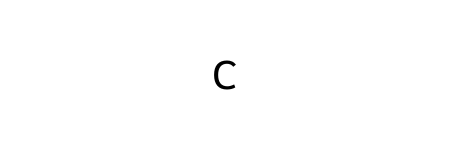

In [27]:
#1380
mol2 = Chem.MolFromSmiles('[c]',sanitize=False)
#c

mol2

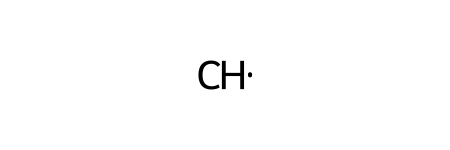

In [36]:
#1019
mol3 = Chem.MolFromSmiles('[CH]')
#C

mol3

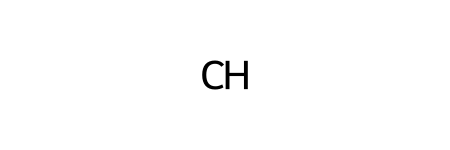

In [37]:
#1873
mol4 = Chem.MolFromSmiles('[cH]',sanitize=False)
#c

mol4

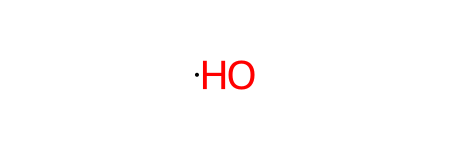

In [43]:
#807
mol5 = Chem.MolFromSmiles('[OH]')
#C(-C)(-O)-O 
mol5

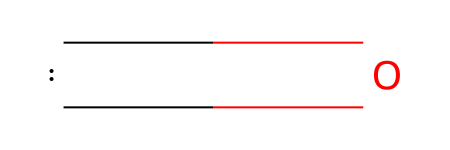

In [39]:
#1917
mol6 = Chem.MolFromSmiles('[O]=[C]')
#O=C
mol6

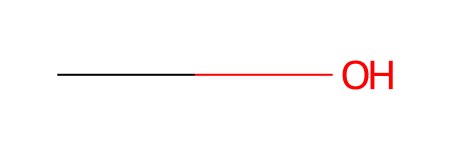

In [40]:
#1602
mol7 = Chem.MolFromSmiles('[OH]-[c]',sanitize=False)
#O-c
mol7

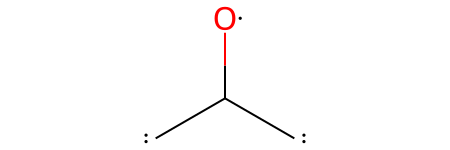

In [41]:
#1950
mol8 = Chem.MolFromSmiles('[CH](-[CH])(-[CH])-[O]')
# C(-C)(-C)-O
mol8

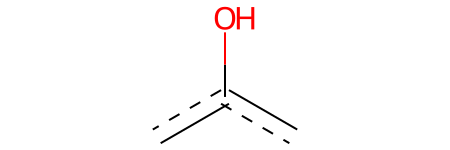

In [42]:
#202
mol9 = Chem.MolFromSmiles('[c](:[c])(:[c])-[OH]',sanitize=False)
# c(:c)(:c)-O
mol9

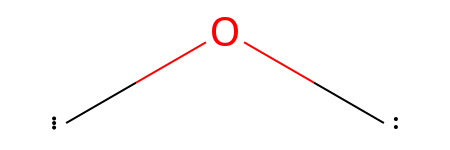

In [43]:
#1126
mol10 = Chem.MolFromSmiles('[O](-[C])-[CH] ')
# O(-C)-C 
mol10

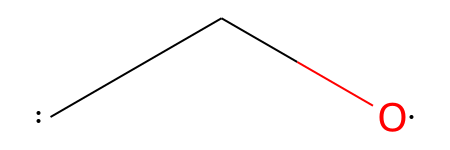

In [44]:
#1136
mol11 = Chem.MolFromSmiles(' [CH2](-[CH])-[O] ')
# C(-C)-O  
mol11

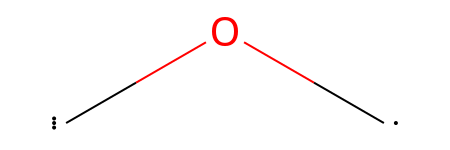

In [45]:
#147
mol12 = Chem.MolFromSmiles('[O](-[C])-[CH2]')
#O(-C)-C 
mol12

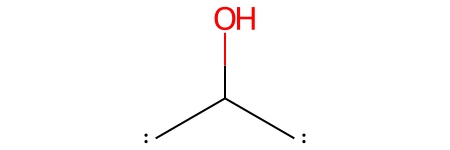

In [46]:
#1487
mol13 = Chem.MolFromSmiles('[CH](-[CH])(-[CH])-[OH]')
#C(-C)(-C)-O 
mol13 

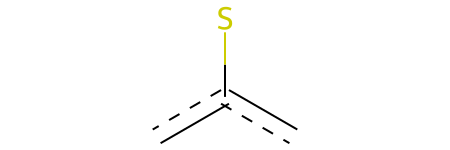

In [47]:
#392
mol14 = Chem.MolFromSmiles('[c](:[cH])(:[c])-[S]',sanitize=False)
#c(:c)(:c)-S
mol14 

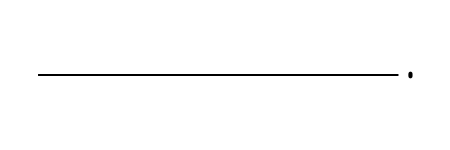

In [48]:
mol14 = Chem.MolFromSmiles('[CH3]-[C]')
#c(:c)(:c)-S
mol14   
    

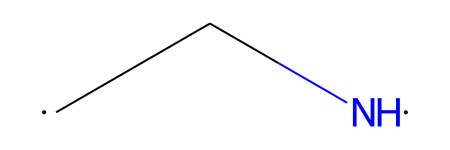

In [49]:
#667
mol15 = Chem.MolFromSmiles(' [CH2](-[CH2])-[NH]')
#C(-C)-N
mol15

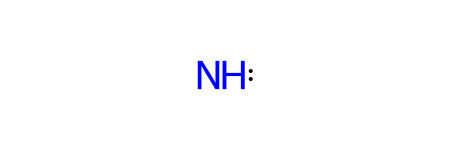

In [50]:
#1152
mol16 = Chem.MolFromSmiles('[NH]')
#N
mol16

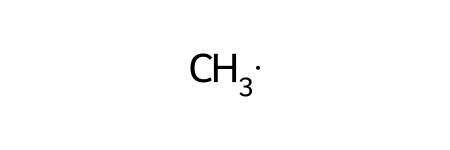

In [51]:
#1057
mol17 = Chem.MolFromSmiles('[CH3]')
#C
mol17

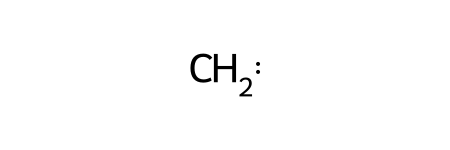

In [52]:
#926
mol18 = Chem.MolFromSmiles('[CH2]')
#C
mol18

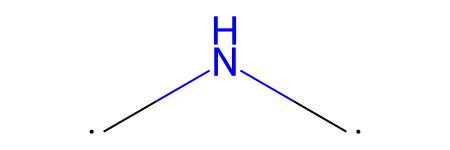

In [53]:
#1308
mol19 = Chem.MolFromSmiles('[NH](-[CH2])-[CH2]')
#N(-C)-C 
mol19

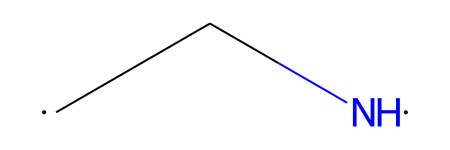

In [54]:
#305
mol20 = Chem.MolFromSmiles('[CH2](-[CH2])-[NH]')
#C(-C)-N 
mol20

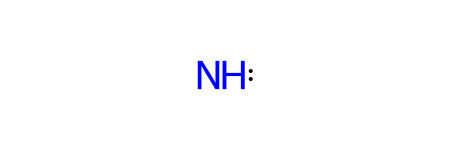

In [55]:
#1114
mol21 = Chem.MolFromSmiles('[NH]')
#N 
mol21

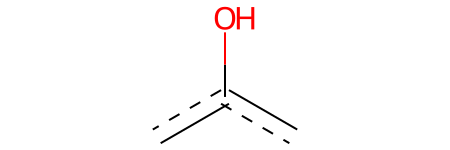

In [31]:
#745
mol2 = Chem.MolFromSmiles('[c](:[cH])(:[cH])-[OH]',sanitize=False)
#c(:c)(:c)-O 
mol2

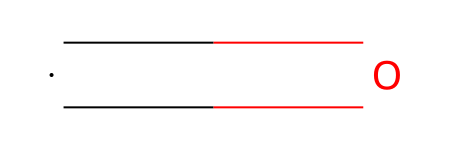

In [57]:
#1004
mol23 = Chem.MolFromSmiles('[O]=[CH]')
#O=C
mol23

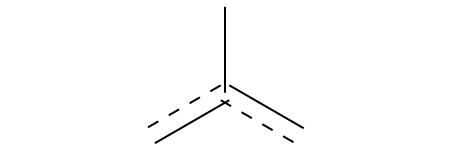

In [58]:
#1417
mol24 = Chem.MolFromSmiles('[c](:[cH])(:[cH])-[C]',sanitize=False)
#c(:c)(:c)-C
mol24

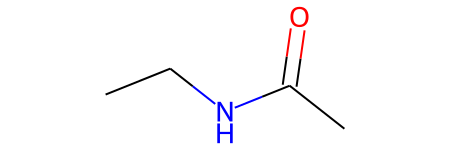

In [30]:
#8
mol1 = Chem.MolFromSmiles('[NH](-[CH2]-[CH2])-[C](-[c])=[O]',sanitize=False)
#N(-C-C)-C(-c)=O
mol1

In [35]:
from rdkit import Chem

mol1 = Chem.MolFromSmiles('[NH](-[CH2]-[CH2])-[C](-[c])=[O]', sanitize=False)
mol2 = Chem.MolFromSmiles('[c](:[cH])(:[cH])-[OH]', sanitize=False)

combined_molecules = []

for atom1 in mol1.GetAtoms():
    for atom2 in mol2.GetAtoms():
        combined_molecule = Chem.RWMol(mol1)
        combined_molecule.ReplaceAtom(atom1.GetIdx(), mol2.GetAtomWithIdx(atom2.GetIdx()))
        combined_molecules.append(combined_molecule.GetMol())

for combined_molecule in combined_molecules:
    print(Chem.MolToSmiles(combined_molecule))



cC(=O)cC[CH2]
cC(=O)[cH]C[CH2]
cC(=O)[cH]C[CH2]
cC(=O)[OH]C[CH2]
cC(=O)Nc[CH2]
cC(=O)N[cH][CH2]
cC(=O)N[cH][CH2]
cC(=O)N[OH][CH2]
cCNC(c)=O
cC(=O)NC[cH]
cC(=O)NC[cH]
cC(=O)NCO
c-c(=O)NC[CH2]
c-c(=O)NC[CH2]
c-c(=O)NC[CH2]
c[OH](=O)NC[CH2]
cC(=O)NC[CH2]
[cH]C(=O)NC[CH2]
[cH]C(=O)NC[CH2]
[CH2]CNC(=O)O
cC(=c)NC[CH2]
cC(=[cH])NC[CH2]
cC(=[cH])NC[CH2]
cC(=[OH])NC[CH2]


In [38]:
from rdkit import Chem
from rdkit.Chem import Draw

mol1 = Chem.MolFromSmiles('[NH](-[CH2]-[CH2])-[C](-[c])=[O]', sanitize=False)
mol2 = Chem.MolFromSmiles('[c](:[cH])(:[cH])-[OH]', sanitize=False)

combined_molecules = []

for atom1 in mol1.GetAtoms():
    for atom2 in mol2.GetAtoms():
        combined_molecule = Chem.RWMol(mol1)
        combined_molecule.ReplaceAtom(atom1.GetIdx(), mol2.GetAtomWithIdx(atom2.GetIdx()))
        combined_molecules.append(combined_molecule.GetMol())

for idx, combined_molecule in enumerate(combined_molecules):
    print(f"Combination {idx + 1}:")
    smiles = Chem.MolToSmiles(combined_molecule)
    print("SMILES:", smiles)
    
    img = Draw.MolToImage(combined_molecule, size=(300, 300))
    img.show()


Combination 1:
SMILES: cC(=O)cC[CH2]
Combination 2:
SMILES: cC(=O)[cH]C[CH2]
Combination 3:
SMILES: cC(=O)[cH]C[CH2]
Combination 4:
SMILES: cC(=O)[OH]C[CH2]
Combination 5:
SMILES: cC(=O)Nc[CH2]
Combination 6:
SMILES: cC(=O)N[cH][CH2]
Combination 7:
SMILES: cC(=O)N[cH][CH2]
Combination 8:
SMILES: cC(=O)N[OH][CH2]
Combination 9:
SMILES: cCNC(c)=O
Combination 10:
SMILES: cC(=O)NC[cH]
Combination 11:
SMILES: cC(=O)NC[cH]
Combination 12:
SMILES: cC(=O)NCO
Combination 13:
SMILES: c-c(=O)NC[CH2]
Combination 14:
SMILES: c-c(=O)NC[CH2]
Combination 15:
SMILES: c-c(=O)NC[CH2]
Combination 16:
SMILES: c[OH](=O)NC[CH2]
Combination 17:
SMILES: cC(=O)NC[CH2]
Combination 18:
SMILES: [cH]C(=O)NC[CH2]
Combination 19:
SMILES: [cH]C(=O)NC[CH2]
Combination 20:
SMILES: [CH2]CNC(=O)O
Combination 21:
SMILES: cC(=c)NC[CH2]
Combination 22:
SMILES: cC(=[cH])NC[CH2]
Combination 23:
SMILES: cC(=[cH])NC[CH2]
Combination 24:
SMILES: cC(=[OH])NC[CH2]


Combination 1:
SMILES: cC(=O)cC[CH2]


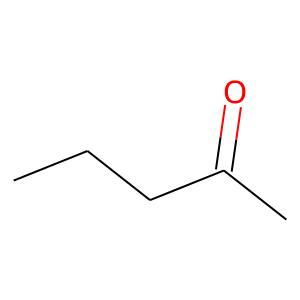

Combination 2:
SMILES: cC(=O)[cH]C[CH2]


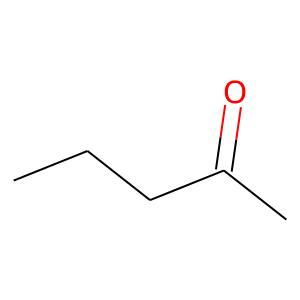

Combination 3:
SMILES: cC(=O)[cH]C[CH2]


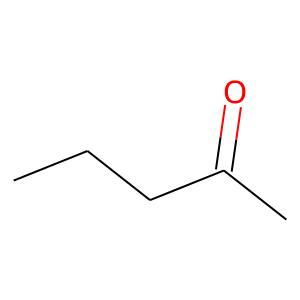

Combination 4:
SMILES: cC(=O)[OH]C[CH2]


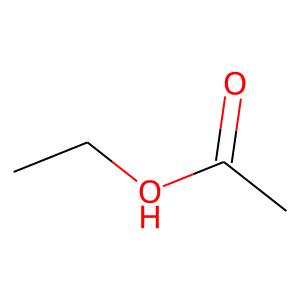

Combination 5:
SMILES: cC(=O)Nc[CH2]


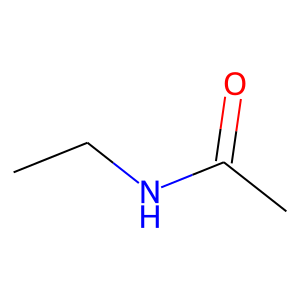

Combination 6:
SMILES: cC(=O)N[cH][CH2]


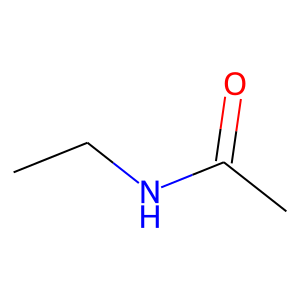

Combination 7:
SMILES: cC(=O)N[cH][CH2]


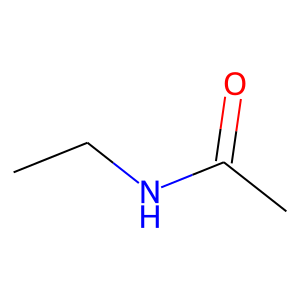

Combination 8:
SMILES: cC(=O)N[OH][CH2]


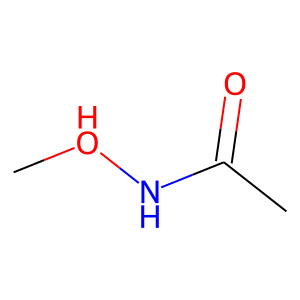

Combination 9:
SMILES: cCNC(c)=O


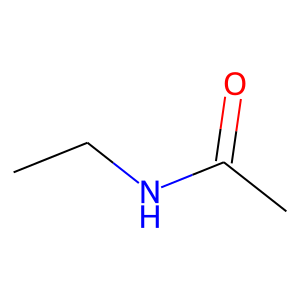

Combination 10:
SMILES: cC(=O)NC[cH]


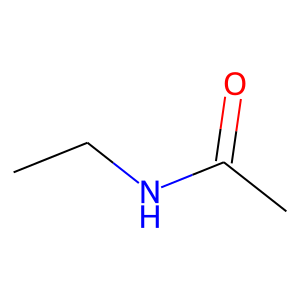

Combination 11:
SMILES: cC(=O)NC[cH]


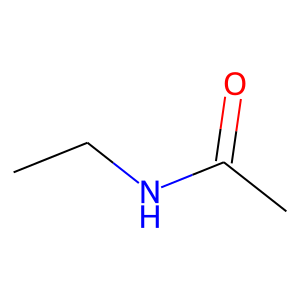

Combination 12:
SMILES: cC(=O)NCO


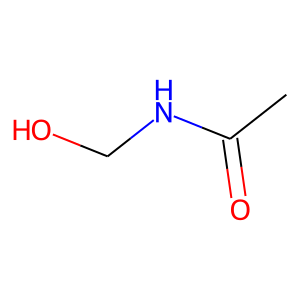

Combination 13:
SMILES: c-c(=O)NC[CH2]


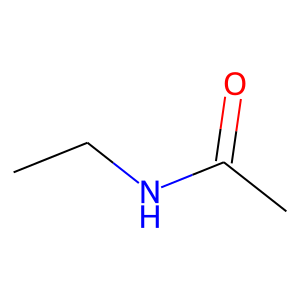

Combination 14:
SMILES: c-c(=O)NC[CH2]


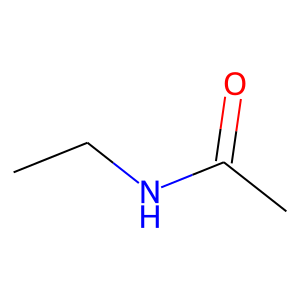

Combination 15:
SMILES: c-c(=O)NC[CH2]


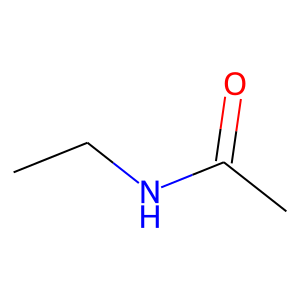

Combination 16:
SMILES: c[OH](=O)NC[CH2]


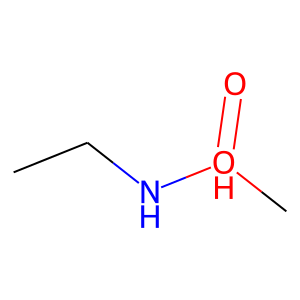

Combination 17:
SMILES: cC(=O)NC[CH2]


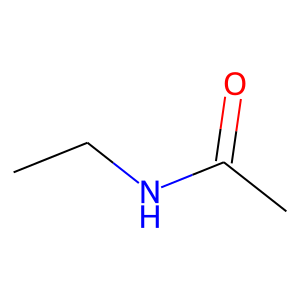

Combination 18:
SMILES: [cH]C(=O)NC[CH2]


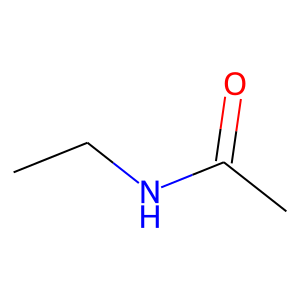

Combination 19:
SMILES: [cH]C(=O)NC[CH2]


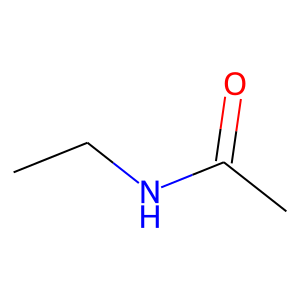

Combination 20:
SMILES: [CH2]CNC(=O)O


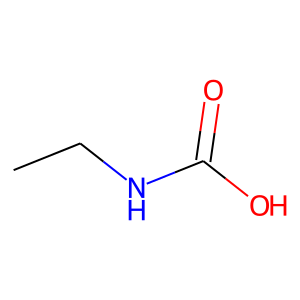

Combination 21:
SMILES: cC(=c)NC[CH2]


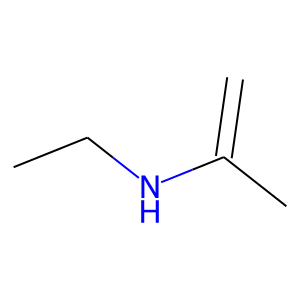

Combination 22:
SMILES: cC(=[cH])NC[CH2]


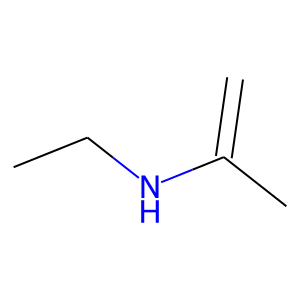

Combination 23:
SMILES: cC(=[cH])NC[CH2]


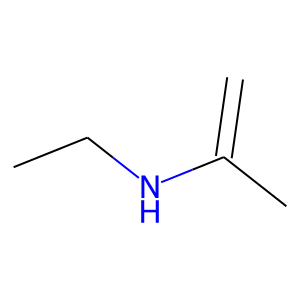

Combination 24:
SMILES: cC(=[OH])NC[CH2]


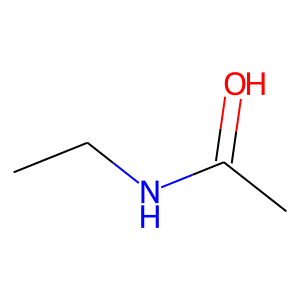

In [39]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

mol1 = Chem.MolFromSmiles('[NH](-[CH2]-[CH2])-[C](-[c])=[O]', sanitize=False)
mol2 = Chem.MolFromSmiles('[c](:[cH])(:[cH])-[OH]', sanitize=False)

combined_molecules = []

for atom1 in mol1.GetAtoms():
    for atom2 in mol2.GetAtoms():
        combined_molecule = Chem.RWMol(mol1)
        combined_molecule.ReplaceAtom(atom1.GetIdx(), mol2.GetAtomWithIdx(atom2.GetIdx()))
        combined_molecules.append(combined_molecule.GetMol())

for idx, combined_molecule in enumerate(combined_molecules):
    print(f"Combination {idx + 1}:")
    smiles = Chem.MolToSmiles(combined_molecule)
    print("SMILES:", smiles)
    
    img = Draw.MolToImage(combined_molecule, size=(300, 300))
    display(img)


Combination 1:
SMILES: O.c


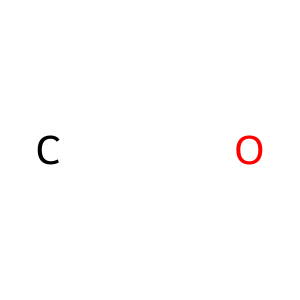

Combination 2:
SMILES: O.[cH]


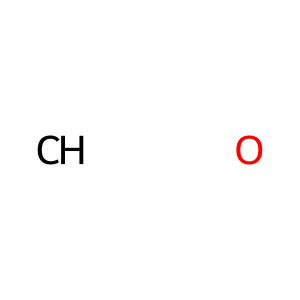

Combination 3:
SMILES: O.cO


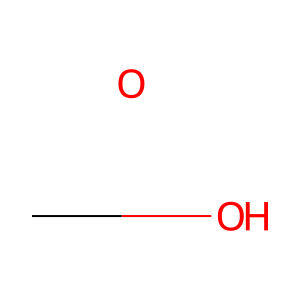

Combination 4:
SMILES: O.cc(c)O


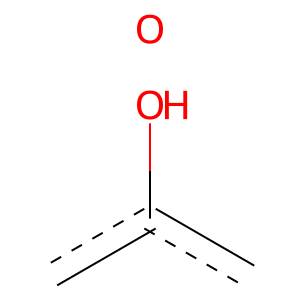

Combination 5:
SMILES: O.cc([cH])S


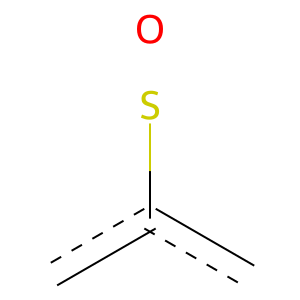

Combination 6:
SMILES: O.[cH]c([cH])O


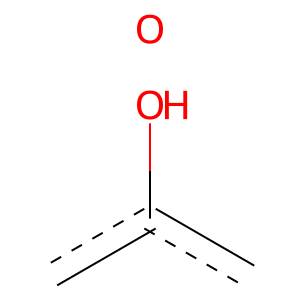

Combination 7:
SMILES: Cc([cH])[cH].O


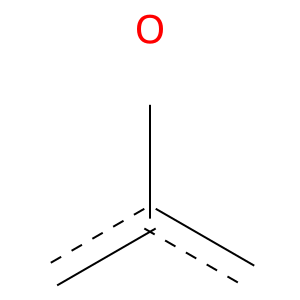

Combination 8:
SMILES: O.cC(=O)NC[CH2]


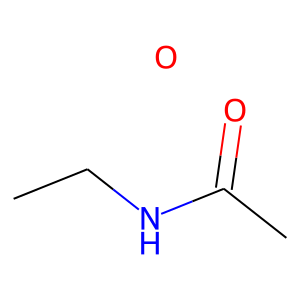

Combination 9:
SMILES: O.c


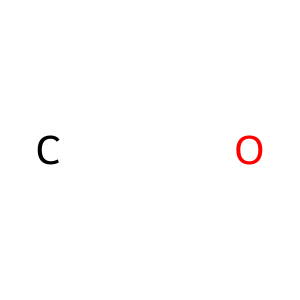

Combination 10:
SMILES: [cH].c


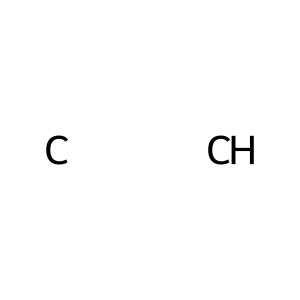

Combination 11:
SMILES: c.cO


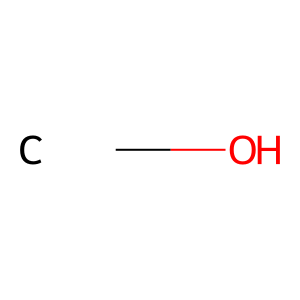

Combination 12:
SMILES: c.cc(c)O


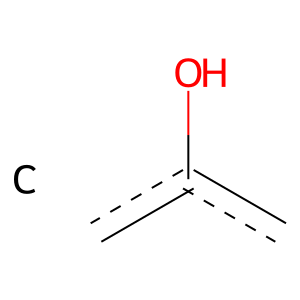

Combination 13:
SMILES: c.cc([cH])S


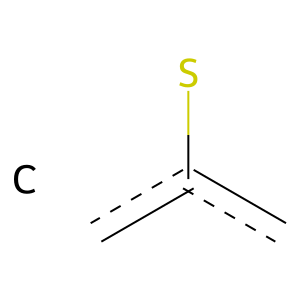

Combination 14:
SMILES: [cH]c([cH])O.c


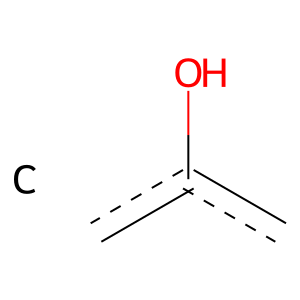

Combination 15:
SMILES: Cc([cH])[cH].c


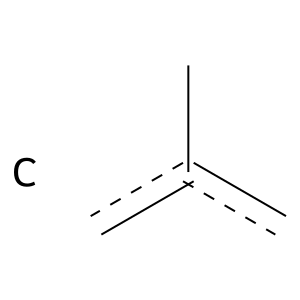

Combination 16:
SMILES: c.cC(=O)NC[CH2]


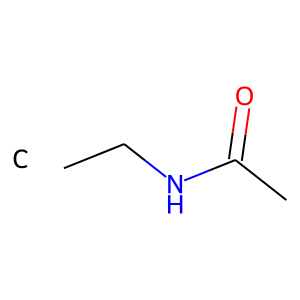

Combination 17:
SMILES: O.[cH]


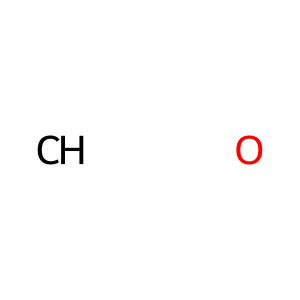

Combination 18:
SMILES: [cH].c


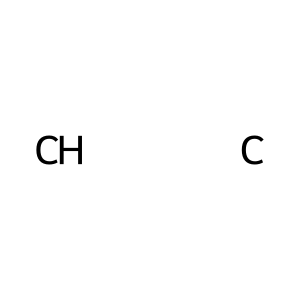

Combination 19:
SMILES: [cH].cO


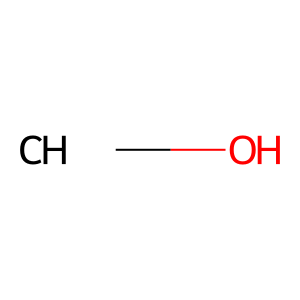

Combination 20:
SMILES: [cH].cc(c)O


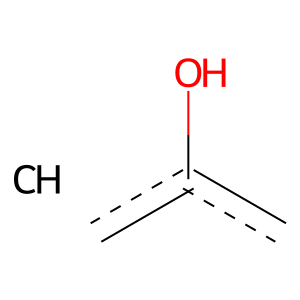

Combination 21:
SMILES: [cH].cc([cH])S


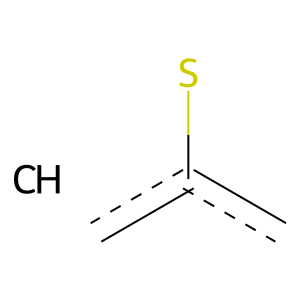

Combination 22:
SMILES: [cH].[cH]c([cH])O


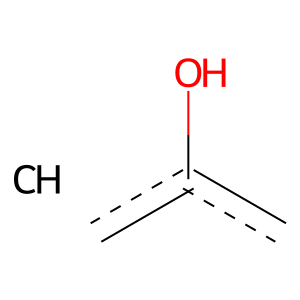

Combination 23:
SMILES: Cc([cH])[cH].[cH]


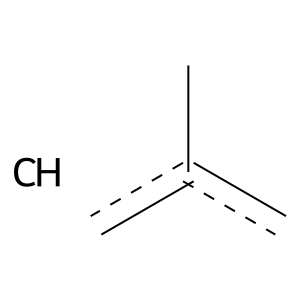

Combination 24:
SMILES: [cH].cC(=O)NC[CH2]


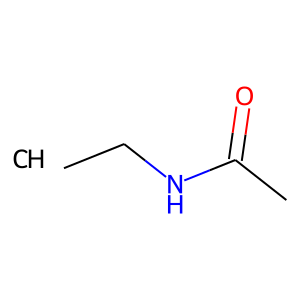

Combination 25:
SMILES: O.cO


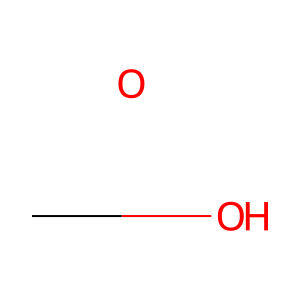

Combination 26:
SMILES: c.cO


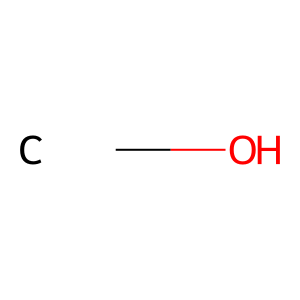

Combination 27:
SMILES: [cH].cO


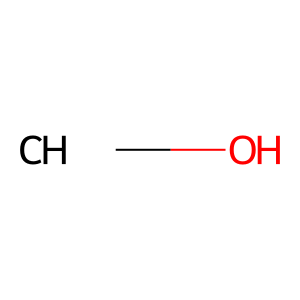

Combination 28:
SMILES: cO.cc(c)O


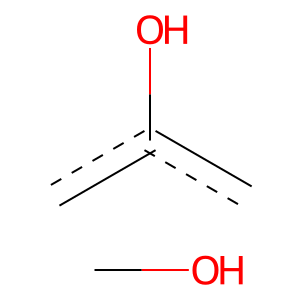

Combination 29:
SMILES: cO.cc([cH])S


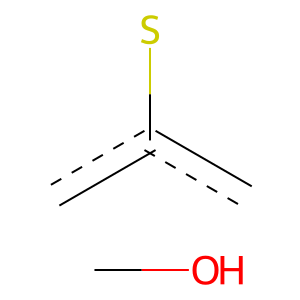

Combination 30:
SMILES: [cH]c([cH])O.cO


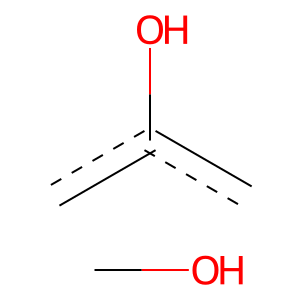

Combination 31:
SMILES: Cc([cH])[cH].cO


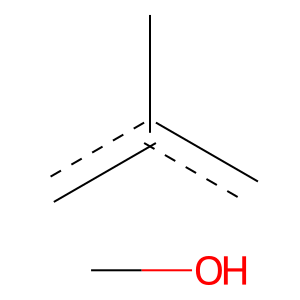

Combination 32:
SMILES: cC(=O)NC[CH2].cO


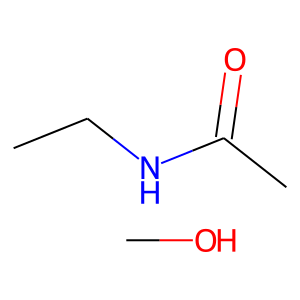

Combination 33:
SMILES: O.cc(c)O


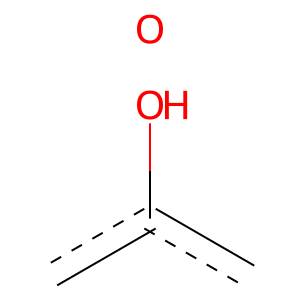

Combination 34:
SMILES: c.cc(c)O


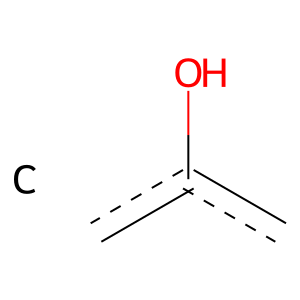

Combination 35:
SMILES: [cH].cc(c)O


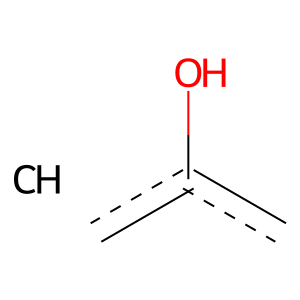

Combination 36:
SMILES: cO.cc(c)O


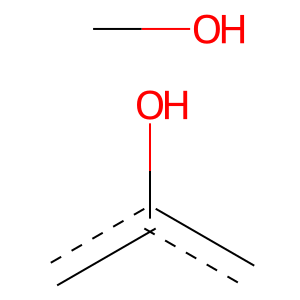

Combination 37:
SMILES: cc([cH])S.cc(c)O


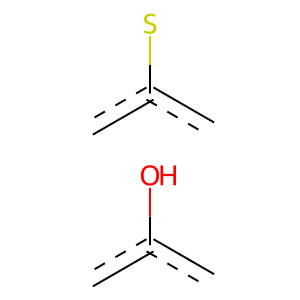

Combination 38:
SMILES: [cH]c([cH])O.cc(c)O


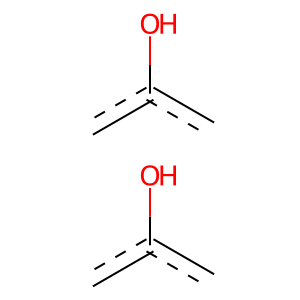

Combination 39:
SMILES: Cc([cH])[cH].cc(c)O


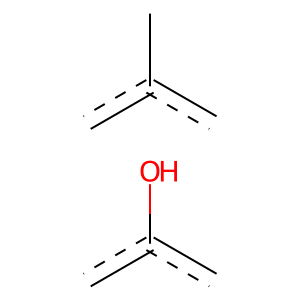

Combination 40:
SMILES: cC(=O)NC[CH2].cc(c)O


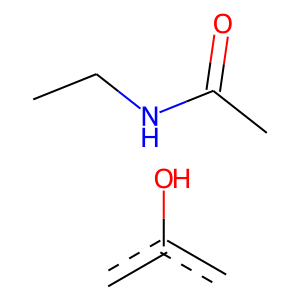

Combination 41:
SMILES: O.cc([cH])S


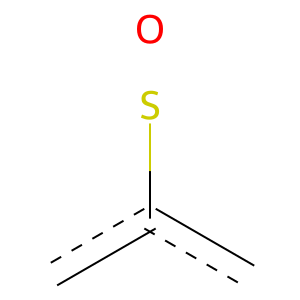

Combination 42:
SMILES: c.cc([cH])S


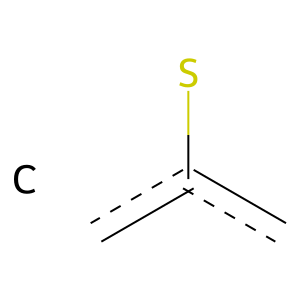

Combination 43:
SMILES: [cH].cc([cH])S


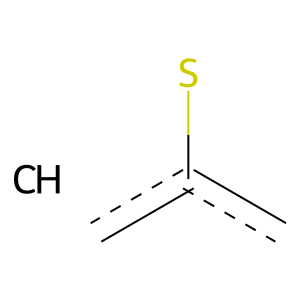

Combination 44:
SMILES: cO.cc([cH])S


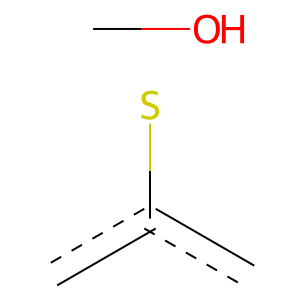

Combination 45:
SMILES: cc([cH])S.cc(c)O


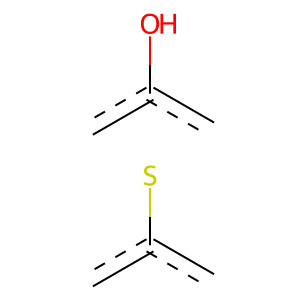

Combination 46:
SMILES: [cH]c([cH])O.cc([cH])S


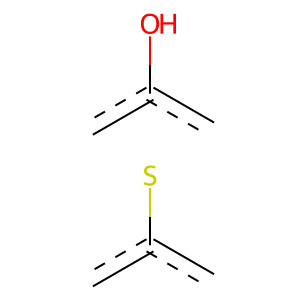

Combination 47:
SMILES: Cc([cH])[cH].cc([cH])S


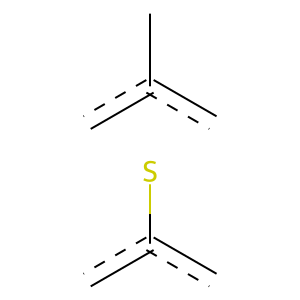

Combination 48:
SMILES: cC(=O)NC[CH2].cc([cH])S


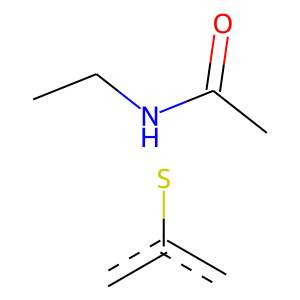

Combination 49:
SMILES: O.[cH]c([cH])O


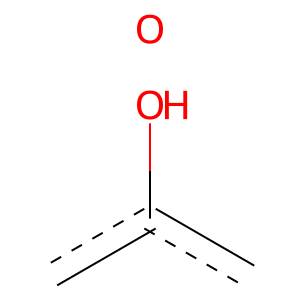

Combination 50:
SMILES: [cH]c([cH])O.c


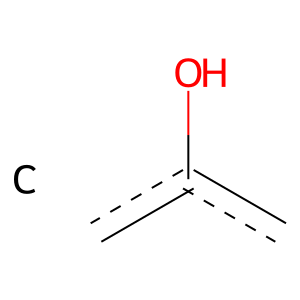

Combination 51:
SMILES: [cH].[cH]c([cH])O


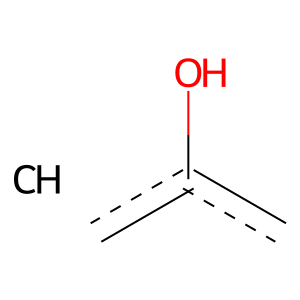

Combination 52:
SMILES: [cH]c([cH])O.cO


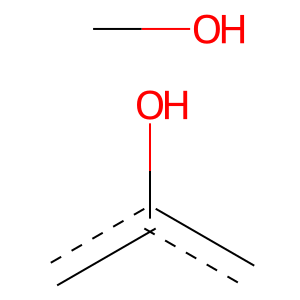

Combination 53:
SMILES: [cH]c([cH])O.cc(c)O


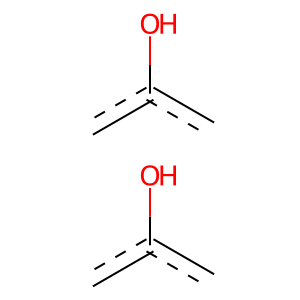

Combination 54:
SMILES: [cH]c([cH])O.cc([cH])S


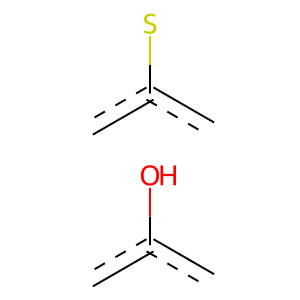

Combination 55:
SMILES: Cc([cH])[cH].[cH]c([cH])O


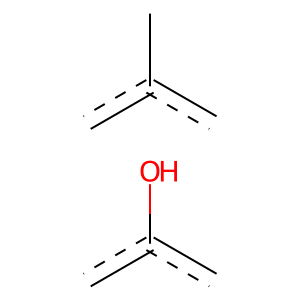

Combination 56:
SMILES: [cH]c([cH])O.cC(=O)NC[CH2]


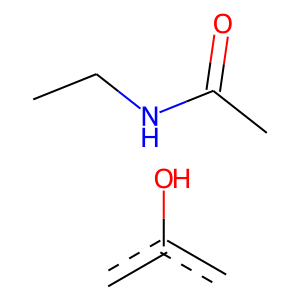

Combination 57:
SMILES: Cc([cH])[cH].O


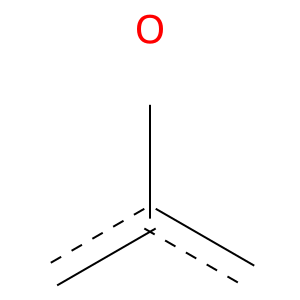

Combination 58:
SMILES: Cc([cH])[cH].c


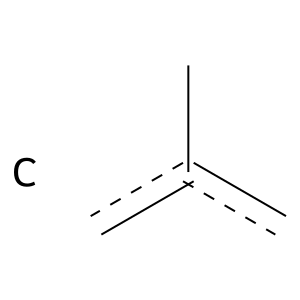

Combination 59:
SMILES: Cc([cH])[cH].[cH]


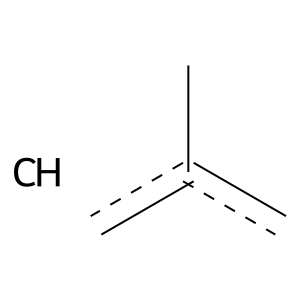

Combination 60:
SMILES: Cc([cH])[cH].cO


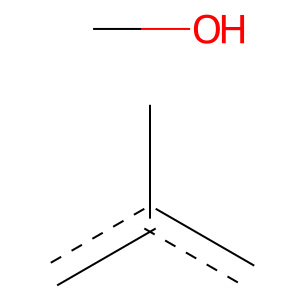

Combination 61:
SMILES: Cc([cH])[cH].cc(c)O


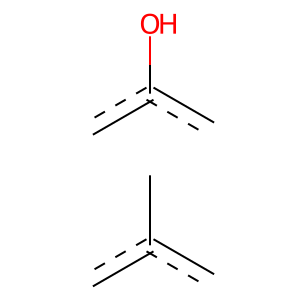

Combination 62:
SMILES: Cc([cH])[cH].cc([cH])S


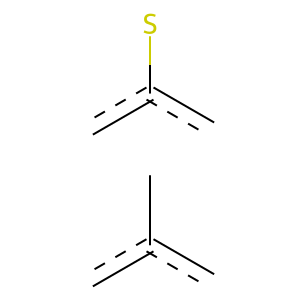

Combination 63:
SMILES: Cc([cH])[cH].[cH]c([cH])O


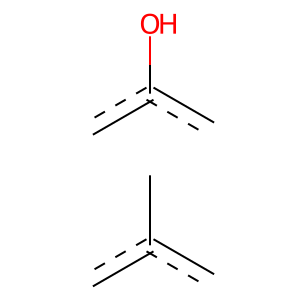

Combination 64:
SMILES: Cc([cH])[cH].cC(=O)NC[CH2]


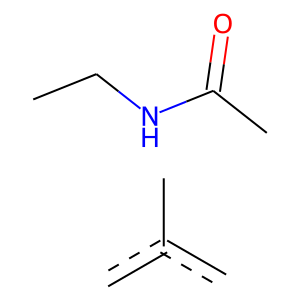

Combination 65:
SMILES: O.cC(=O)NC[CH2]


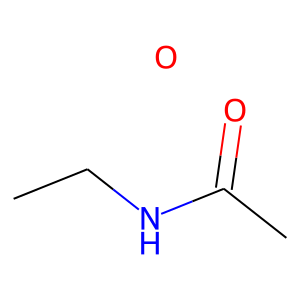

Combination 66:
SMILES: c.cC(=O)NC[CH2]


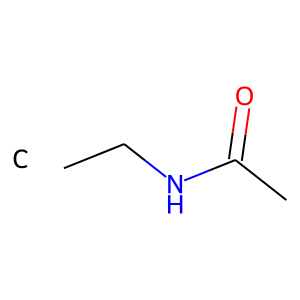

Combination 67:
SMILES: [cH].cC(=O)NC[CH2]


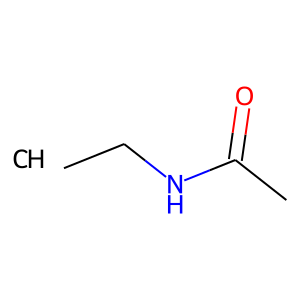

Combination 68:
SMILES: cC(=O)NC[CH2].cO


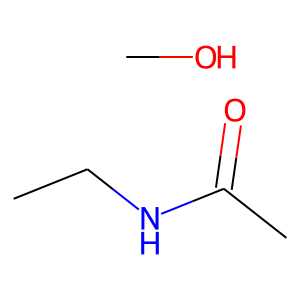

Combination 69:
SMILES: cC(=O)NC[CH2].cc(c)O


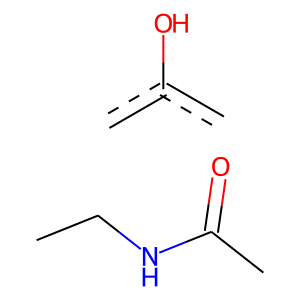

Combination 70:
SMILES: cC(=O)NC[CH2].cc([cH])S


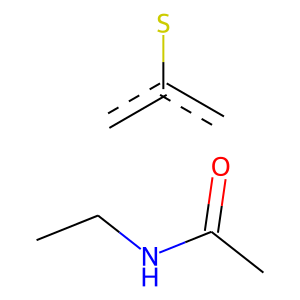

Combination 71:
SMILES: [cH]c([cH])O.cC(=O)NC[CH2]


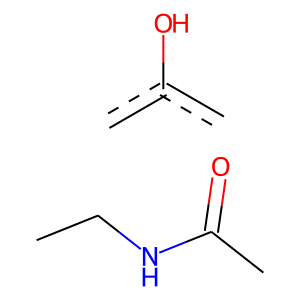

Combination 72:
SMILES: Cc([cH])[cH].cC(=O)NC[CH2]


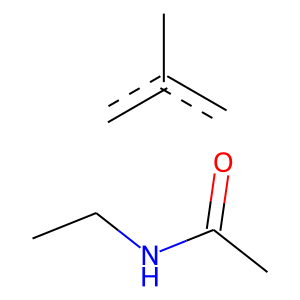

In [21]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display
from itertools import product
# List of molecules
molecules = [
    Chem.MolFromSmiles('[O]', sanitize=False),
    Chem.MolFromSmiles('[c]', sanitize=False),
    Chem.MolFromSmiles('[cH]',sanitize=False),
    Chem.MolFromSmiles('[OH]-[c]',sanitize=False),
    Chem.MolFromSmiles('[c](:[c])(:[c])-[OH]',sanitize=False),
    Chem.MolFromSmiles('[c](:[cH])(:[c])-[S]',sanitize=False),
    Chem.MolFromSmiles('[c](:[cH])(:[cH])-[OH]',sanitize=False),
    Chem.MolFromSmiles('[c](:[cH])(:[cH])-[C]',sanitize=False),
    Chem.MolFromSmiles('[NH](-[CH2]-[CH2])-[C](-[c])=[O]',sanitize=False)
    # Add more molecules here
]

combined_molecules = []

# Generate all possible combinations of molecules
for mol1, mol2 in product(molecules, repeat=2):
    if mol1 != mol2:  # Avoid combining a molecule with itself
        combined_molecule = Chem.CombineMols(mol1, mol2)
        combined_molecules.append(combined_molecule)

# Display each combination
for idx, combined_molecule in enumerate(combined_molecules):
    print(f"Combination {idx + 1}:")
    smiles = Chem.MolToSmiles(combined_molecule)
    print("SMILES:", smiles)
    
    img = Draw.MolToImage(combined_molecule, size=(300, 300))
    display(img)


In [28]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display
from itertools import product

# List of molecules
molecules = [
  #  Chem.MolFromSmiles('[O]', sanitize=False),
    Chem.MolFromSmiles('[C]', sanitize=False),
  #  Chem.MolFromSmiles('[CH]',sanitize=False),
  #  Chem.MolFromSmiles('[cH]', sanitize=False),
  #  Chem.MolFromSmiles('[NH]',sanitize=False),
  #  Chem.MolFromSmiles('[CH3]',sanitize=False),
 #   Chem.MolFromSmiles('[OH]',sanitize=False),
    Chem.MolFromSmiles('[O]',sanitize=False),
    Chem.MolFromSmiles('[S]',sanitize=False),
   # Chem.MolFromSmiles('[[O-]]',sanitize=False),

]

combined_molecules = list(product(*[molecules] * len(molecules)))

# Display each combination
for idx, combined_molecule in enumerate(combined_molecules):
    combined_molecule = Chem.CombineMols(*combined_molecule)
    if combined_molecule:
        print(f"Combination {idx + 1}:")
        smiles = Chem.MolToSmiles(combined_molecule)
        print("SMILES:", smiles)
    
        img = Draw.MolToImage(combined_molecule, size=(300, 300))
        display(img)


ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.CombineMols(Mol, Mol, Mol)
did not match C++ signature:
    CombineMols(class RDKit::ROMol mol1, class RDKit::ROMol mol2, class RDGeom::Point3D offset=<rdkit.Geometry.rdGeometry.Point3D object at 0x000001800FEDFCC0>)

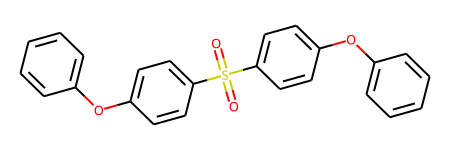

In [77]:
mol3 = Chem.MolFromSmiles('C1=CC(=CC=C1OC2=CC=CC=C2)[S](C3=CC=C(C=C3)OC4=CC=CC=C4)(=O)=O')
mol3

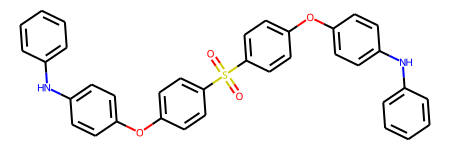

In [78]:
mol4 = Chem.MolFromSmiles('C1=CC(=CC=C1OC2=CC=C(C=C2)NC3=CC=CC=C3)[S](C4=CC=C(C=C4)OC5=CC=C(C=C5)NC6=CC=CC=C6)(=O)=O')
mol4

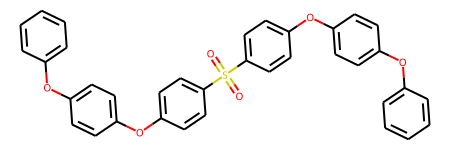

In [79]:
mol5 = Chem.MolFromSmiles('C1=CC(=CC=C1OC2=CC=C(C=C2)OC3=CC=CC=C3)[S](C4=CC=C(C=C4)OC5=CC=C(C=C5)OC6=CC=CC=C6)(=O)=O')
mol5

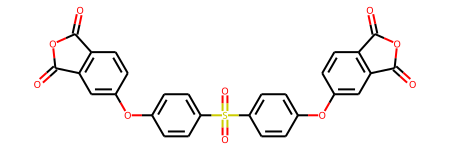

In [80]:
mol6 = Chem.MolFromSmiles('C1=CC(=CC=C1OC2=CC3=C(C=C2)C(=O)OC3=O)[S](C4=CC=C(C=C4)OC5=CC6=C(C=C5)C(=O)OC6=O)(=O)=O')
mol6

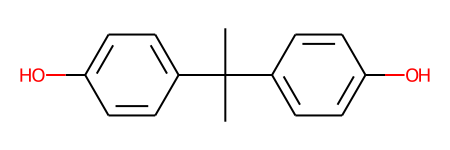

In [24]:
mol6 = Chem.MolFromSmiles('C(C)(C)(C1=CC=C(C=C1)O)C1=CC=C(C=C1)O')
mol6

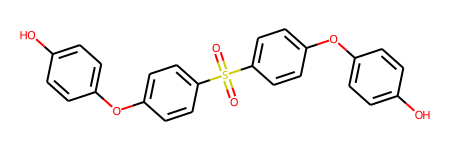

In [87]:
mol6 = Chem.MolFromSmiles('C1=CC(=CC=C1OC2=CC=C(C=C2)O)[S](C3=CC=C(C=C3)OC4=CC=C(C=C4)O)(=O)=O')
mol6



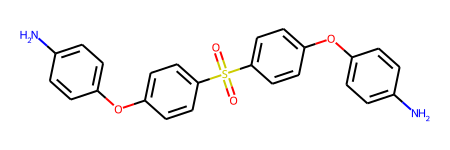

In [88]:
mol6 = Chem.MolFromSmiles('C1=CC(=CC=C1OC2=CC=C(C=C2)N)[S](C3=CC=C(C=C3)OC4=CC=C(C=C4)N)(=O)=O')
mol6


In [17]:
data2 = pd.read_excel('E:/python/rdkit/water-test.xlsx')


In [18]:
fp = morgan_fp(0,2048)
data2['a-fp'] = data2['a-smile'].apply(fp)

In [19]:
x_a2=np.array(list(data2['a-fp']))

In [20]:
Xnew=x_a2
ynew = model.predict(Xnew)
#print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))
ynew

array([12.52169312, 11.95277469, 11.38007171, 13.05698848, 13.48167261,
       13.9412803 , 13.48167261, 13.75381685, 11.33116344, 12.7110936 ,
       11.27408705, 12.7110936 , 13.75381685, 13.75381685, 10.53160337,
       14.39552754, 12.02358812, 12.27970253, 11.41881208, 11.866359  ,
       14.71672903, 12.75931465, 10.28408721, 19.04949465])